In [3]:
import torch
import torch.nn
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
#print("GUP name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Deice is:', device, '\n')
#print('Total number of GPUs:', torch.cuda.device_count())

Deice is: cpu 



In [5]:
from diffusers import DDPMScheduler
from PIL import Image
import numpy as np

# Hyperparameter: number of steps to turn clear image to noise
max_timesteps = 200

# Initialize DDPM Scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps,
                                beta_start=0.0001,
                                beta_end=0.02)

def plot_images(timesteps, noisy_images):
  fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 15))
  for i, t in enumerate(timesteps):
    img = noisy_images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
    img = np.clip(img, 0, 1)  # Ensure the values are in [0, 1]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')
  plt.savefig('imgx.png')
  plt.show()

def get_img_subregion(img, x, y, w, h):
  return img[:, y:y+h, x:x+w]

def get_corruption_region(img, w=20, h=20):
  _, H, W = img.shape
  x = torch.randint(0, W - w + 1, (1,))
  y = torch.randint(0, H - h + 1, (1,))
  return x, y, w, h

/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
if False:
  import fiftyone
  dataset = fiftyone.zoo.load_zoo_dataset(
      "coco-2017",
      split="validation",
      label_types=["detections", "segmentations"],
      classes=["person", "car"],
      max_samples=500,
  )

  dataset.export(
      export_dir="coco_subset_export",
      dataset_type=fiftyone.types.COCODetectionDataset,
      label_field="detections",
  )


In [7]:
root = "coco_subset_export/data"
annFile = "coco_subset_export/labels.json"

dataset = torchvision.datasets.CocoDetection(root=root, annFile=annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [9]:
import torchvision
from PIL import Image
import torchvision.transforms as T
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

def get_pred(img):
  model.eval()

  with torch.no_grad():
    prediction = model([torch.Tensor(img).to(device)])

  pred = prediction[0]

  labels = pred['labels'].tolist()
  label_names = [COCO_INSTANCE_CATEGORY_NAMES[i] if i < len(COCO_INSTANCE_CATEGORY_NAMES) else COCO_INSTANCE_CATEGORY_NAMES[0] for i in labels]

  #print(pred["boxes"][0])
  #print(COCO_INSTANCE_CATEGORY_NAMES[pred["labels"][0]])

  return pred["boxes"], label_names

/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/5527/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import cv2

def downsample_img(image, bbox, size=(224, 224)):
  C, H, W = image.shape
  target_H, target_W = size

  image_hwc = np.transpose(image, (1, 2, 0))
  resized_image = cv2.resize(image_hwc, size, interpolation=cv2.INTER_LINEAR)
  resized_image = np.transpose(resized_image, (2, 0, 1))

  scale_x = target_W / W
  scale_y = target_H / H
  x, y, w, h = bbox
  scaled_bbox = (
      int(x * scale_x),
      int(y * scale_y),
      int(w * scale_x),
      int(h * scale_y)
  )

  return resized_image, scaled_bbox


In [18]:
from PIL import Image

dataset_orig_imgs = []
dataset_masked_imgs = []
subregions = []

for i, datapoint in enumerate(iter(dataset)):
  image = torch.Tensor(np.transpose(np.array(datapoint[0]), (2, 0, 1)))
  img_shape = image.shape

  mask_idx = 0

  bboxes = datapoint[1][mask_idx]["bbox"]
  x1, y1, w, h = bboxes

  label_name = datapoint[1][mask_idx]["supercategory"]
  label_name = datapoint[1][mask_idx]
  #print("label idx:", label_name)
  #new_dataset_labels.append(COCO_INSTANCE_CATEGORY_NAMES[label_name])

  #print("label:", COCO_INSTANCE_CATEGORY_NAMES[label_name])

  x = int(x1); y = int(y1); w = int(w); h = int(h);

  sub_img = torch.Tensor(get_img_subregion(image, x, y, w, h))
  sub_img_shape = sub_img.shape

  jumps = 8
  timesteps = torch.arange(0, max_timesteps, jumps)
  noise = torch.randn(sub_img_shape) * 255
  noisy_images = [torch.clone(torch.Tensor(image))]

  for j, t in enumerate(timesteps):
    noisy_image = noise_scheduler.add_noise(sub_img, noise, t)
    img_curr = torch.clone(image)
    img_curr[:, y:y+h, x:x+w] = noisy_image
    noisy_images.append((img_curr/255))

  scaled_img, scaled_bbox = downsample_img(image.numpy(), (x, y, w ,h), size=(224, 224))
  scaled_masked_img, _ = downsample_img(noisy_images[-1].numpy(), (x, y, w ,h), size=(224, 224))

  print(scaled_img.shape)
  print(scaled_masked_img.shape)

  dataset_orig_imgs.append(torch.Tensor(scaled_img))
  dataset_masked_imgs.append(torch.Tensor(scaled_masked_img))
  subregions.append(torch.Tensor(scaled_bbox))

# plot_images(timesteps, noisy_images)
# 
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(np.transpose(image, (1, 2, 0)))
# axs[0].axis('off')
# axs[0].set_title("Original Image")
# 
# axs[1].imshow(np.transpose(new_dataset_images[0], (1, 2, 0)))
# axs[1].axis('off')
# axs[1].set_title("Noised Image")

# plt.tight_layout()
# plt.show()

orig_imgs = torch.stack(dataset_orig_imgs) / 255
masked_imgs = torch.stack(dataset_masked_imgs)
subregions = torch.stack(subregions)


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 22

In [19]:
print(orig_imgs.size())
print(masked_imgs.size())
print(subregions.size())

torch.Size([500, 3, 224, 224])
torch.Size([500, 3, 224, 224])
torch.Size([500, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9244316..3.9357758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9156635..3.1145523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.96516..2.8195415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.321396..1.9115179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0178807..2.3635433].


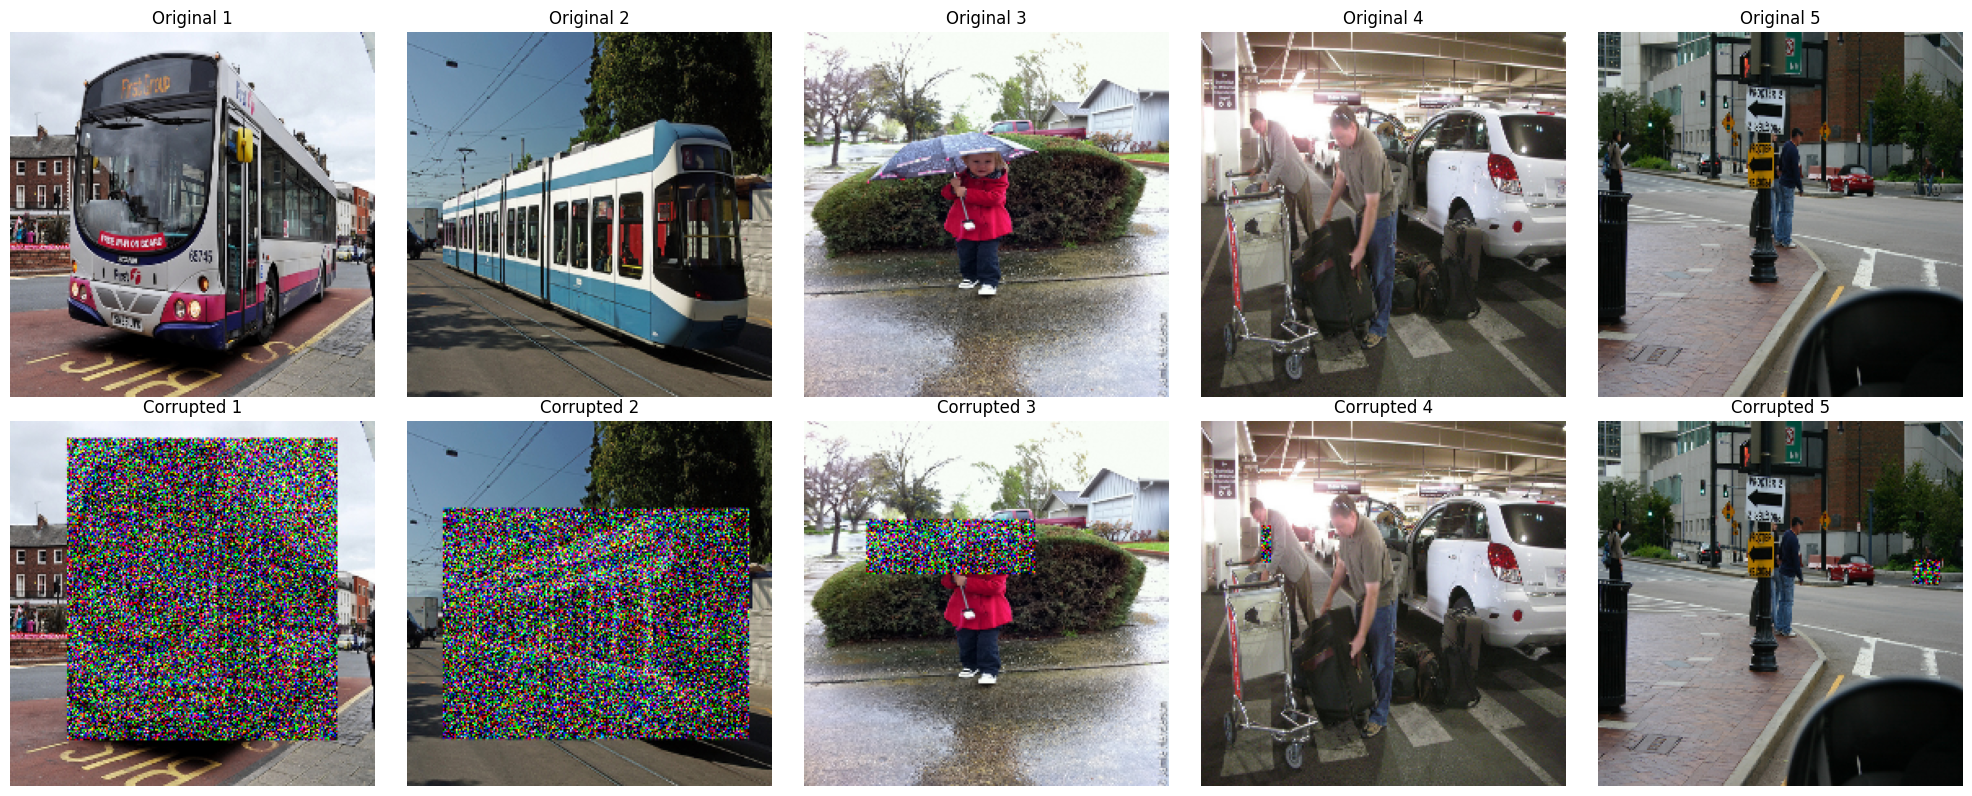

In [21]:
import matplotlib.pyplot as plt
import torch

def plot_images_side_by_side(ground_truth, mask, num_images=5):
    num_images = min(num_images, ground_truth.shape[0], mask.shape[0])

    plt.figure(figsize=(4 * num_images, 8))
    
    for i in range(num_images):
        # Top row: Ground truth
        plt.subplot(2, num_images, i + 1)
        img = ground_truth[i]
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = img.permute(1, 2, 0)
        plt.imshow(img.squeeze(), cmap='gray' if img.ndim == 2 or img.shape[-1] == 1 else None)
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Bottom row: Mask
        plt.subplot(2, num_images, num_images + i + 1)
        mask_img = mask[i]
        if mask_img.ndim == 3 and mask_img.shape[0] in [1, 3]:
            mask_img = mask_img.permute(1, 2, 0)
        plt.imshow(mask_img.squeeze(), cmap='gray')
        plt.title(f"Corrupted {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images_side_by_side(orig_imgs, masked_imgs)